# CAM and SeCAM Implementation

### Importing Required Libraries

In [1]:
import numpy as np
import cv2
from skimage.segmentation import slic
from torchvision import models, transforms
from torch.nn import functional as F
from torch import topk
import matplotlib.pyplot as plt
import matplotlib

### Common Functions to load class labels, preprocess image, load model and extract features

In [2]:
def load_class_labels(file_path):
    """
    Load class labels from a file.
    :param file_path: Path to the file containing class labels
    :return: List of class labels
    """
    class_labels = []
    with open(file_path, 'r') as f:
        all_lines = f.readlines()
        labels = [line.split('\n') for line in all_lines]
        for label_list in labels:
            current_class = [name.split(',') for name in label_list][0][0][10:]
            class_labels.append(current_class)
    return class_labels

In [3]:
def preprocess_image(image_path):
    """
    Preprocess the input image.
    :param image_path: Path to the input image
    :return: Preprocessed image tensor, original image, image dimensions
    """
    image = cv2.imread(image_path)
    original_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image_tensor = preprocess(image)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    return image_tensor, original_image, height, width

In [4]:
def load_model_and_extract_features():
    """
    Load the pretrained ResNet50 model and extract features.
    :return: Model, features blob list, softmax weights
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT).eval()
    features_blobs = []

    def hook_feature(module, input, output):
        features_blobs.append(output.data.cpu().numpy())

    # Hook the feature extractor to get the convolutional features from 'layer4'
    model._modules.get('layer4').register_forward_hook(hook_feature)

    # Get the softmax weights
    params = list(model.parameters())
    softmax_weights = np.squeeze(params[-2].data.numpy())

    return model, features_blobs, softmax_weights

In [5]:
def get_topk_predictions(model, image_tensor, topk_predictions):
    """
    Get the top k predictions for the input image.
    :param model: Pretrained model
    :param image_tensor: Preprocessed image tensor
    :param topk_predictions: Number of top predictions to get
    :return: Top k class indices
    """
    outputs = model(image_tensor)
    probabilities = F.softmax(outputs, dim=1).data.squeeze()
    class_indices = topk(probabilities, topk_predictions)[1].int()
    return class_indices

### Functions to generate CAM

In [6]:
def generate_CAM(feature_maps, softmax_weights, class_indices):
    """
    Generate Class Activation Maps (CAM).
    :param feature_maps: Convolutional feature maps
    :param softmax_weights: Weights of the fully connected layer
    :param class_indices: Class indices
    :return: List of CAMs for the specified class indices
    """
    batch_size, num_channels, height, width = feature_maps.shape
    output_cams = []

    for class_idx in class_indices:
        # Generate the CAM for the specific class index
        cam = softmax_weights[class_idx].dot(feature_maps.reshape((num_channels, height * width)))
        cam = cam.reshape(height, width)
        cam = cam - np.min(cam)  # Normalize CAM to be non-negative
        cam = cam / np.max(cam)  # Scale CAM to be in range [0, 1]
        cam_img = np.uint8(255 * cam)  # Convert to uint8 format
        output_cams.append(cam_img)

    return output_cams

In [7]:
def display_and_save_CAM(CAMs, width, height, original_image, class_indices, class_labels, save_name, plot=False):
    """
    Display and save the CAM images.
    :param CAMs: List of CAMs
    :param width: Width of the original image
    :param height: Height of the original image
    :param original_image: Original input image
    :param class_indices: Class indices
    :param class_labels: List of all class names
    :param save_name: Name to save the output image
    :param plot: Whether to display the image
    """
    matplotlib.rcParams['figure.figsize'] = 15, 12

    for i, cam in enumerate(CAMs):
        heatmap = cv2.applyColorMap(cv2.resize(cam, (width, height)), cv2.COLORMAP_JET)
        result = heatmap * 0.3 + original_image * 0.5
        # Put class label text on the result
        cv2.putText(result, class_labels[class_indices[i]], (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        cv2.imwrite(f"outputs/CAM_{save_name}_{i}.jpg", result)

        # Display the result
        if plot:
            image = plt.imread(f"outputs/CAM_{save_name}_{i}.jpg")
            plt.imshow(image)
            plt.axis('off')
            plt.show()

In [8]:
def generate_and_save_CAM(image_path, topk_predictions):
    """
    Generate and save CAM for the specified image and topk predictions.
    :param image_path: Path to the input image
    :param topk_predictions: Number of top predictions to generate CAM for
    """
    # Load the class labels
    class_labels = load_class_labels('LOC_synset_mapping.txt')

    # Read and preprocess the image
    image_tensor, original_image, height, width = preprocess_image(image_path)

    # Load the model and extract features
    model, features_blobs, softmax_weights = load_model_and_extract_features()

    # Get the top k predictions
    class_indices = get_topk_predictions(model, image_tensor, topk_predictions)

    # Generate CAM for the top predictions
    CAMs = generate_CAM(features_blobs[0], softmax_weights, class_indices)

    # Display and save the CAM results
    save_name = image_path.split('/')[-1].split('.')[0]
    display_and_save_CAM(CAMs, width, height, original_image, class_indices, class_labels, save_name)

### Functions to generate SeCAM

In [9]:
def generate_seCAM(feature_maps, softmax_weights, class_indices, segments):
    """
    Generate Segmentation-based Class Activation Maps (SeCAM).
    :param feature_maps: Convolutional feature maps
    :param softmax_weights: Weights of the fully connected layer
    :param class_indices: Class indices
    :param segments: Segmented image regions
    :return: List of SeCAMs for the specified class indices
    """
    batch_size, num_channels, height, width = feature_maps.shape
    output_seCAMs = []

    for class_idx in class_indices:
        cam = softmax_weights[class_idx].dot(feature_maps.reshape((num_channels, height * width)))
        cam = cam.reshape(height, width)
        cam = np.maximum(cam, 0)
        cam = cam / np.max(cam)

        # Resize segments to match cam size
        segments_resized = cv2.resize(segments.astype(np.float32), (width, height), interpolation=cv2.INTER_NEAREST)
        segments_resized = segments_resized.astype(int)

        seCAM = np.zeros_like(cam)
        for seg_val in np.unique(segments_resized):
            mask = (segments_resized == seg_val)
            seCAM[mask] = cam[mask].mean()

        output_seCAMs.append(seCAM)
    return output_seCAMs

In [47]:
def display_and_save_seCAM(SeCAMs, width, height, original_image, save_name, secam_threshold, plot=False):
    """
    Display and save the SeCAM images.
    :param SeCAMs: List of SeCAMs
    :param width: Width of the original image
    :param height: Height of the original image
    :param original_image: Original input image
    :param save_name: Name to save the output image
    :param secam_threshold: Threshold to mask significant regions
    :param plot: Whether to display the image
    """
    matplotlib.rcParams['figure.figsize'] = 15, 12

    for i, seCAM in enumerate(SeCAMs):
        seCAM = np.uint8(255 * seCAM)
        seCAM_resized = cv2.resize(seCAM, (width, height))

        # Create a mask of the significant regions
        mask = seCAM_resized > (secam_threshold * seCAM_resized.max())

        # Create a black background image
        black_bg = np.zeros_like(original_image)

        # Apply the mask to the original image
        result = original_image.copy()
        result[~mask] = black_bg[~mask]

        # Save the result
        cv2.imwrite(f"outputs/SeCAM_{save_name}_{i}.jpg", result)

        # Display the result
        if plot:
            image = plt.imread(f"outputs/SeCAM_{save_name}_{i}.jpg")
            plt.imshow(image)
            plt.axis('off')
            plt.show()

In [51]:
def generate_and_save_seCAM(image_path, topk_predictions, num_segments=50, compactness=10, secam_threshold=0.8):
    """
    Generate and save SeCAM for the specified image and topk predictions.
    :param image_path: Path to the input image
    :param topk_predictions: Number of top predictions to generate SeCAM for
    :param num_segments: Number of segments for SLIC
    :param compactness: Compactness parameter for SLIC
    :param secam_threshold: Threshold to mask significant regions in SeCAM
    """
    # Load the class labels
    class_labels = load_class_labels('LOC_synset_mapping.txt')

    # Read and preprocess the image
    image_tensor, original_image, height, width = preprocess_image(image_path)

    # Load the model and extract features
    model, features_blobs, softmax_weights = load_model_and_extract_features()

    # Get the top k predictions
    class_indices = get_topk_predictions(model, image_tensor, topk_predictions)

    # Generate superpixels using SLIC
    segments = slic(original_image, n_segments=num_segments, compactness=compactness, start_label=1)

    # Generate SeCAM for the top predictions
    SeCAMs = generate_seCAM(features_blobs[0], softmax_weights, class_indices, segments)

    # Display and save the SeCAM results
    save_name = image_path.split('/')[-1].split('.')[0] + f"_seg_{num_segments}_ts_{secam_threshold}"
    display_and_save_seCAM(SeCAMs, width, height, original_image, save_name, secam_threshold)

## Visualizing CAM and SeCAM

In [33]:
def compare_CAM_and_Original(image_path, topk_predictions):
    """
    Compare CAM and the original image by creating subplots.
    :param image_path: Path to the input image
    :param topk_predictions: Number of top predictions to generate CAM for
    """
    # Generate and save CAM
    generate_and_save_CAM(image_path, topk_predictions)

    # Load images for comparison
    base_name = image_path.split('/')[-1].split('.')[0]
    original_image = plt.imread(image_path)
    cam_image = plt.imread(f"outputs/CAM_{base_name}_0.jpg")

    # Create subplot for original and CAM
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(cam_image)
    ax[1].set_title('CAM')
    ax[1].axis('off')

    plt.show()

##### CAM output for dogs.jpg

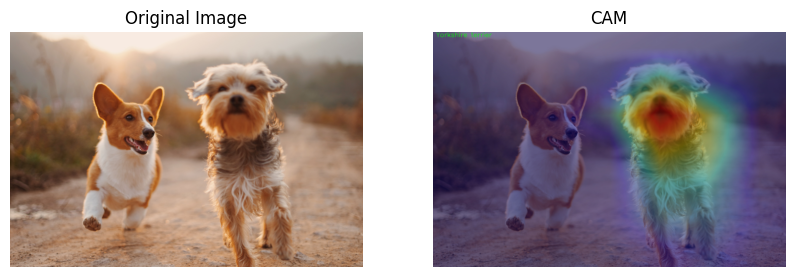

In [22]:
compare_CAM_and_Original("images/dogs.jpg", 5)

##### CAM output for bird.jpg

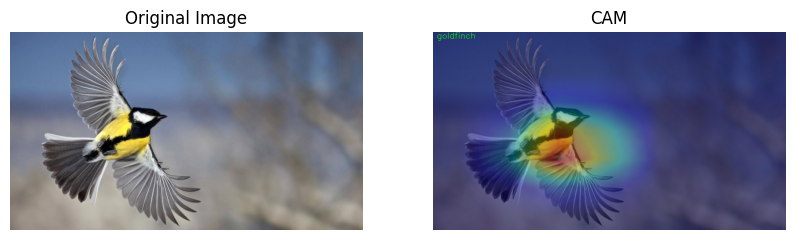

In [25]:
compare_CAM_and_Original("images/bird.jpg", 5)

##### Compare difference between CAMs for different image classes for dogs.jpg

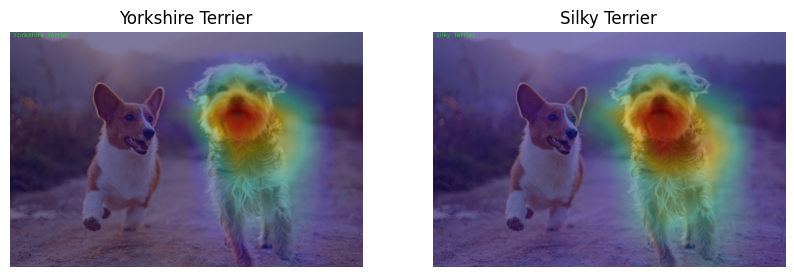

In [24]:
CAM_1 = plt.imread(f"outputs/CAM_dogs_0.jpg")
CAM_2 = plt.imread(f"outputs/CAM_dogs_4.jpg")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(CAM_1)
ax[0].set_title('Yorkshire Terrier')
ax[0].axis('off')

ax[1].imshow(CAM_2)
ax[1].set_title('Silky Terrier')
ax[1].axis('off')

plt.show()

##### Compare difference between CAMs for different image classes for bird.jpg

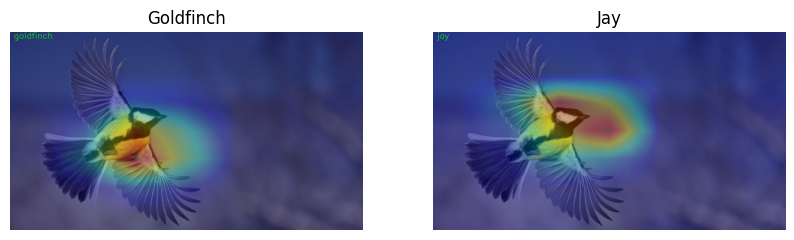

In [27]:
CAM_1 = plt.imread(f"outputs/CAM_bird_0.jpg")
CAM_2 = plt.imread(f"outputs/CAM_bird_2.jpg")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(CAM_1)
ax[0].set_title('Goldfinch')
ax[0].axis('off')

ax[1].imshow(CAM_2)
ax[1].set_title('Jay')
ax[1].axis('off')

plt.show()

In [44]:
def compare_CAM_and_SeCAM(image_path, topk_predictions):
    """
    Compare CAM and SeCAM by creating subplots.
    :param image_path: Path to the input image
    :param topk_predictions: Number of top predictions to generate CAM and SeCAM for
    """
    # Generate and save CAM
    generate_and_save_CAM(image_path, topk_predictions)

    # Generate and save SeCAM with different parameters
    num_segments_list = [50, 100, 150]
    secam_threshold_list = [0, 0.6, 0.8, 0.9]
    for num_segments in num_segments_list:
        for secam_threshold in secam_threshold_list:
            generate_and_save_seCAM(image_path, topk_predictions, num_segments=num_segments, compactness=10, secam_threshold=secam_threshold)

    # Load images for comparison
    base_name = image_path.split('/')[-1].split('.')[0]
    original_image = plt.imread(image_path)
    cam_image = plt.imread(f"outputs/CAM_{base_name}_0.jpg")

    # Create subplot for original and CAM
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(cam_image)
    ax[1].set_title('CAM')
    ax[1].axis('off')

    plt.show()

    # Create subplots for original, CAM, and SeCAM with different parameters
    fig, axes = plt.subplots(len(num_segments_list), len(secam_threshold_list), figsize=(15, 15))

    for i, num_segments in enumerate(num_segments_list):
        for j, secam_threshold in enumerate(secam_threshold_list):
            secam_image = plt.imread(f"outputs/SeCAM_{base_name}_seg_{num_segments}_ts_{secam_threshold}_0.jpg")

            if j == 0:
                axes[i, j].imshow(original_image)
                axes[i, j].set_title(f'Original Image')
                axes[i, j].axis('off')
            else:
                axes[i, j].imshow(secam_image)
                axes[i, j].set_title(f'SeCAM\nThreshold: {secam_threshold}\nSegments: {num_segments}')
                axes[i, j].axis('off')

    plt.show()

##### Compare difference between CAM and SeCAMs with different parameters for dogs.jpg

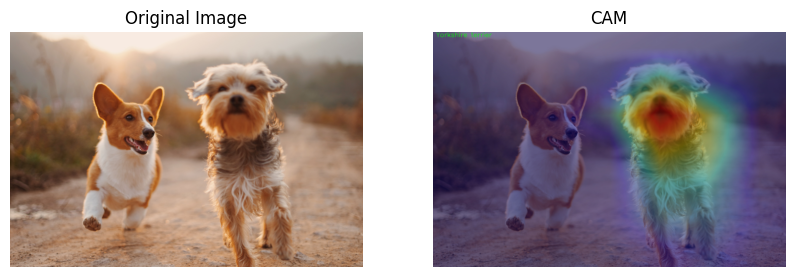

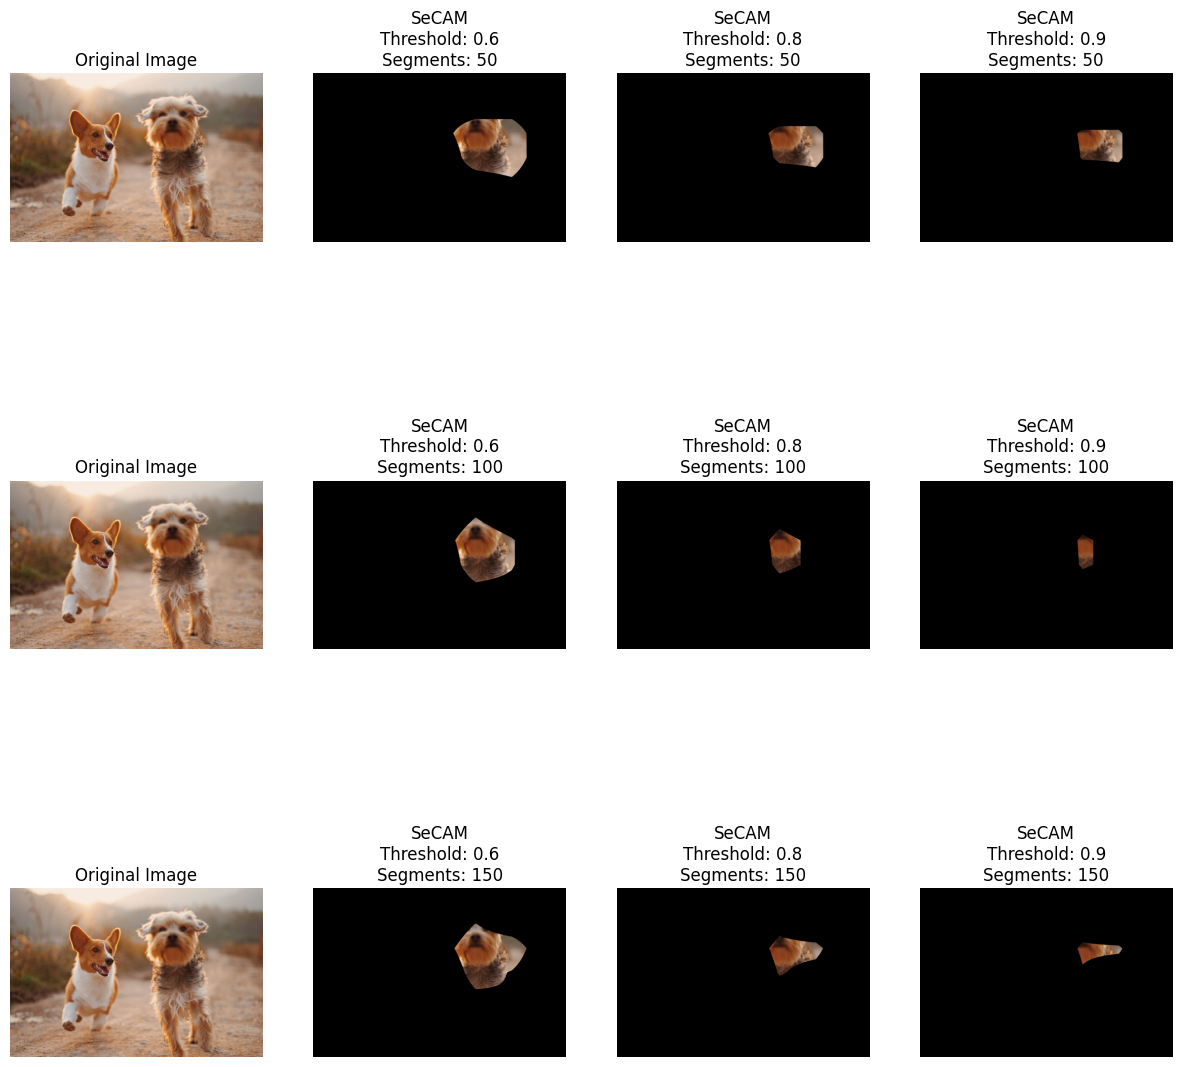

In [45]:
compare_CAM_and_SeCAM("images/dogs.jpg", 1)

##### Compare difference between CAM and SeCAMs with different parameters for tiger.jpg

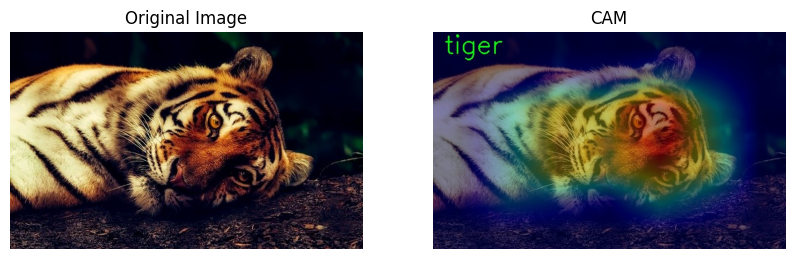

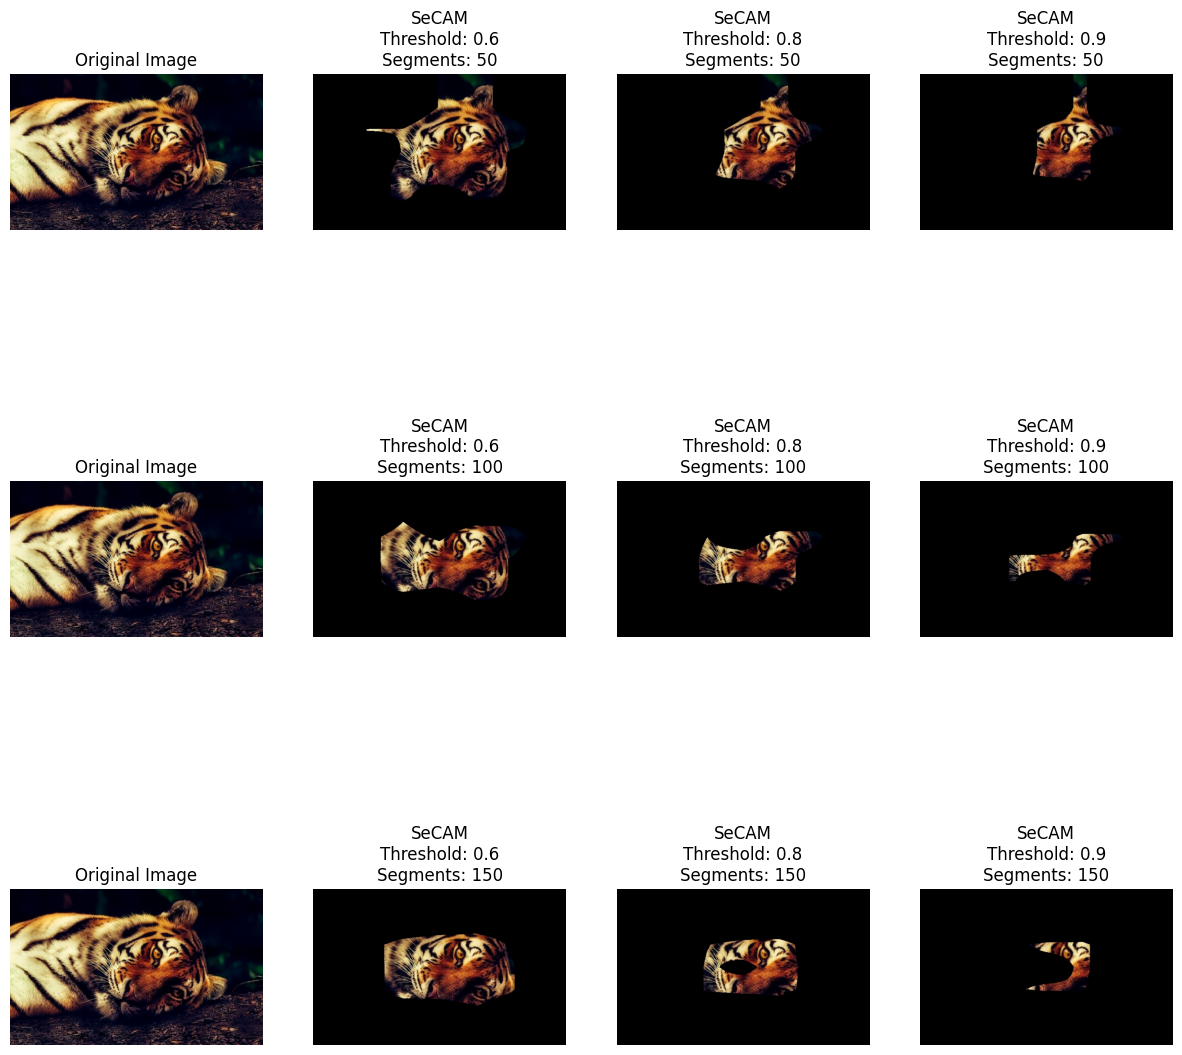

In [52]:
compare_CAM_and_SeCAM("images/tiger.jpg", 1)

In [48]:
import requests
url = "https://drive.google.com/uc?id=1gtP1McQNNnNkQl9d4cz8aiUsnCkXWOI3&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
   f.write(r.content)

In [49]:
!unzip input.zip

Archive:  input.zip
   creating: input/
  inflating: input/image_2.jpg       
  inflating: input/image_1.jpg       
